In [1]:
import pandas as pd
import numpy as np

In [2]:
with open('Korean_movie_reviews_2016.txt', encoding='utf-8') as f:
    docs = [doc.strip().split('\t') for doc in f]
    docs = [(doc[0], int(doc[1])) for doc in docs if len(doc) == 2]
    texts, labels = zip(*docs)

In [3]:
words_list = [doc.strip().split() for doc in texts]

In [4]:
print(words_list[:2])

[['부산', '행', '때문', '너무', '기대하고', '봤'], ['한국', '좀비', '영화', '어색하지', '않게', '만들어졌', '놀랍']]


In [5]:
total_words = []
for words in words_list:
    total_words.extend(words)

In [6]:
from collections import Counter
c = Counter(total_words)

In [7]:
max_features = 10000
common_words = [ word for word, count in c.most_common(max_features)]
# 빈도를 기준으로 상위 10000개의 단어들만 선택

In [8]:
# 각 단어에 대해서 index 생성하기
words_dic ={}
for index, word in enumerate(common_words):
    words_dic[word]=index+1

In [10]:
# 각 문서를 상위 10000개 단어들에 대해서 index 번호로 표현하기
filtered_indexed_words = []
for review in words_list:
    indexed_words=[]
    for word in review:
        try:
            indexed_words.append(words_dic[word])
        except:
            pass
    filtered_indexed_words.append(indexed_words)

In [11]:
filtered_indexed_words[0]

[204, 249, 121, 2, 345, 3]

In [12]:
docs_len = [len(doc)for doc in filtered_indexed_words]

In [13]:
df = pd.DataFrame(docs_len, columns=["doc_len"])

array([[<AxesSubplot: title={'center': 'doc_len'}>]], dtype=object)

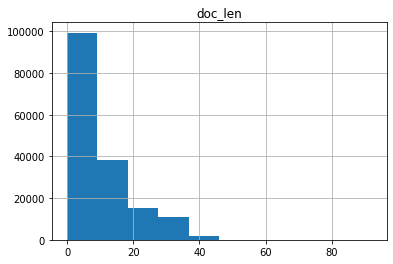

In [14]:
df.hist()

In [15]:
df.describe()

,doc_len
count,165384.000000
mean,10.785910
std,8.590067
min,0.000000
25%,5.000000
50%,8.000000
75%,14.000000
max,92.000000


In [16]:
from tensorflow.keras.preprocessing import sequence
max_len = 40
X = sequence.pad_sequences(filtered_indexed_words, maxlen=max_len)

In [17]:
from tensorflow.keras.utils import to_categorical
y_one_hot = to_categorical(labels)

In [19]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.1)

In [20]:
len(y_test)

16539

In [21]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [22]:
model = models.Sequential()
model.add(layers.Embedding(max_features+1, 128, input_length=max_len))
model.add(layers.Conv1D(32, 5, activation='relu')) 
model.add(layers.MaxPool1D(2)) 
model.add(layers.Conv1D(16, 3, activation='relu')) 
model.add(layers.MaxPool1D(2)) 
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 128)           1280128   
                                                                 
 conv1d (Conv1D)             (None, 36, 32)            20512     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 16)            1552      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 8, 16)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 128)               0

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
checkpoint_filepath = './temp/checkpoint_kr'
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', 
                     save_weights_only=True, save_best_only=True)

In [24]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics='accuracy')

In [26]:
history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.1, 
                   callbacks=[es, mc])

Epoch 1/20
1047/1047 [==============================] - 21s 19ms/step - loss: 0.2916 - accuracy: 0.8744 - val_loss: 0.2524 - val_accuracy: 0.8973
Epoch 2/20
1047/1047 [==============================] - 18s 17ms/step - loss: 0.2195 - accuracy: 0.9129 - val_loss: 0.2385 - val_accuracy: 0.9035
Epoch 3/20
1047/1047 [==============================] - 18s 18ms/step - loss: 0.1947 - accuracy: 0.9238 - val_loss: 0.2579 - val_accuracy: 0.9028
Epoch 4/20
1047/1047 [==============================] - 18s 18ms/step - loss: 0.1707 - accuracy: 0.9345 - val_loss: 0.2455 - val_accuracy: 0.9034
Epoch 5/20
1047/1047 [==============================] - 18s 17ms/step - loss: 0.1466 - accuracy: 0.9443 - val_loss: 0.2645 - val_accuracy: 0.9020
Epoch 5: early stopping


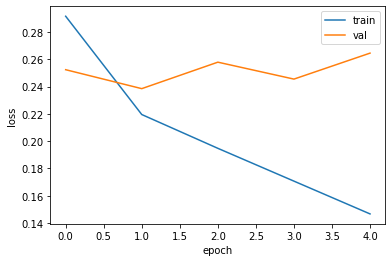

In [27]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

In [28]:
model.load_weights(checkpoint_filepath)

In [30]:
test_loss, test_acc = model.evaluate(X_test,y_test)

517/517 [==============================] - 1s 2ms/step - loss: 0.2418 - accuracy: 0.9019


In [31]:
test_acc

0.9019287824630737

In [32]:
model.predict(X_test[0:1])

1/1 [==============================] - 0s 106ms/step


array([[9.9995971e-01, 4.0281215e-05]], dtype=float32)

In [33]:
y_test[0]

array([1., 0.], dtype=float32)